In [285]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import re
from dateutil.parser import parse
from collections import defaultdict
from sklearn.linear_model import * 
from functools import reduce
from tqdm import tqdm

In [147]:
null = None
data_full = [eval(l) for l in open('datasets/130k_wine_data.json')][0]

In [272]:
def find_year(title):
    pattern = re.compile("\d{4,4}")
    return [int(year) for year in re.findall(pattern, title) if int(year) > 1940 and int(year) < 2017]

data = [d for d in data_full if d['price'] and d['price'] <= 150 and len(find_year(d['title'])) == 1]
len(data)

115584

 Data Exploration
 ===

Data Fields:
---
1. `Points`: the number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)
2. `Title`: the title of the wine review, which often contains the vintage if you're interested in extracting that feature
3. `Variety`: the type of grapes used to make the wine (ie Pinot Noir)
4. `Description`: a few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
5. `Country`: the country that the wine is from
6. `Province`: the province or state that the wine is from
7. `Region 1`: the wine growing area in a province or state (ie Napa)
8. `Region 2`: sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank
9. `Winery`: the winery that made the wine
10. `Designation`: the vineyard within the winery where the grapes that made the wine are from
11. `Price`: the cost for a bottle of the wine
12. `Taster Name`: name of the person who tasted and reviewed the wine
13. `Taster Twitter Handle`: Twitter handle for the person who tasted and reviewed the wine

In [273]:
for k in data[0]:
    print(k + ': ' + str(len(list(set([d[k] for d in data])))))

variety: 685
country: 43
taster_name: 20
taster_twitter_handle: 16
description: 106529
title: 106211
points: 21
winery: 15410
price: 147
region_1: 1172
region_2: 18
province: 415
designation: 33686


In [274]:
popular_winery = defaultdict(int)
for d in data:
    popular_winery[d['winery']] += 1
popular_winery = [(w, popular_winery[w]) for w in popular_winery]
popular_winery = sorted(popular_winery, key=lambda x: x[1], reverse=True)

In [275]:
popular_wineries = []
count = 0
for w in popular_winery:
    count += w[1]
    popular_wineries.append(w[0])
    if count >= 100000:
        break

In [276]:
len(popular_wineries)

6858

In [277]:
print(count)

100003


In [267]:
data_selected = [d for d in data if d['winery'] in popular_wineries]

In [268]:
len(data_selected)

100003

In [269]:
random.shuffle(data_selected)
train = data_selected[:60000]
valid = data_selected[60000:80000]
test  = data_selected[80000:]

In [278]:
one_hot_features = ['country', 'designation', 'province', 'region_1', 'region_2', 'variety', 'winery']
one_hot_bins = {k: set([d[k] for d in data_selected]) for k in one_hot_features}

def featurize(data, keys):
    def feat(datum, keys):
        feature_vector = [[int(datum[k] == b) for b in one_hot_bins[k]] for k in keys if k in one_hot_features]
        return reduce(lambda a, b: a + b, feature_vector) if len(feature_vector) > 0 else []
    
    one_hot = list(map(lambda x: feat(x, keys), tqdm(data)))
    
    if 'year' in keys:
        year = list(map(lambda x: find_year(x['title'])[0], data))
        return [[1] + [y] + hot for y, hot in zip(year, one_hot)]
    
    return one_hot

In [271]:
len(X[0])

7239

In [279]:
count = 0
increment = []
for w in popular_winery:
    count += w[1]
    increment.append((w[0], count))

In [282]:
x = list(range(len(data)))

In [283]:
y = []; j = 0
for i in range(len(data)):
    y.append(j + 1)
    if i == increment[j][1]:
        j += 1

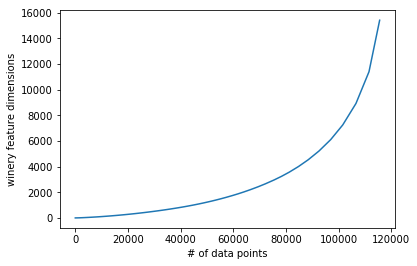

In [284]:
plt.plot(x, y, label=x)
plt.xlabel("# of data points")
plt.ylabel("winery feature dimensions")
plt.show()

In [286]:
price_by_winery = defaultdict(list)
for d in data:
    price_by_winery[d['winery']].append(d['price'])

In [287]:
mean_price_by_winery = {w: np.mean(price_by_winery[w]) for w in price_by_winery}

In [288]:
wineries = set([d['winery'] for d in data])

In [289]:
popular_wineries = {w[0]: w[1] for w in popular_winery}

In [290]:
x, y = zip(*[(popular_wineries[w], mean_price_by_winery[w]) for w in wineries])

In [291]:
plt.scatter(x, y)
plt.xlabel('Popularity of winery')
plt.ylabel('Mean wine price by winery')

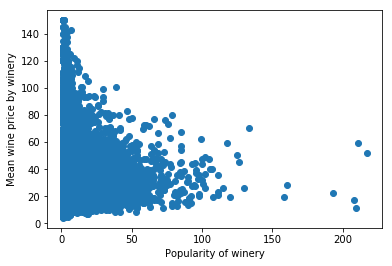

In [292]:
plt.show()

In [293]:
price_by_year = defaultdict(list)
for d in data:
    price_by_year[find_year(d['title'])[0]].append(d['price'])

In [294]:
mean_price_by_year = {y: np.mean(price_by_year[y]) for y in price_by_year}

In [295]:
years = set([find_year(d['title'])[0] for d in data])

In [296]:
x, y = zip(*[(year, mean_price_by_year[year]) for year in years])

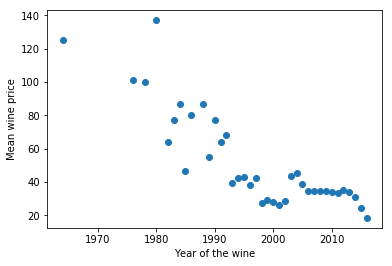

In [297]:
plt.scatter(x, y)
plt.xlabel('Year of the wine')
plt.ylabel('Mean wine price')
plt.show()

In [304]:
X = featurize(train, ['year', 'variety', 'winery'])
y = [d['price'] for d in train]


100%|██████████| 60000/60000 [02:13<00:00, 450.30it/s]


NameError: name 'LinearRegqession' is not defined

In [305]:
reg = LinearRegression()
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [220]:
def mse(predictions, labels):
    return np.mean([(p - y) ** 2 for p, y in zip(predictions, labels)])

In [ ]:
p = reg.predict(X)

In [300]:
X_year = featurize(valid, ['year'])
y = [d['price'] for d in valid]

100%|██████████| 20000/20000 [00:03<00:00, 6560.72it/s]


In [301]:
reg.fit(X_year, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [302]:
p = reg.predict(X_year)

In [303]:
mse(p, y)

528.912771235896

In [298]:
prices = [int(d['price']) for d in data if d['price'] < 200]

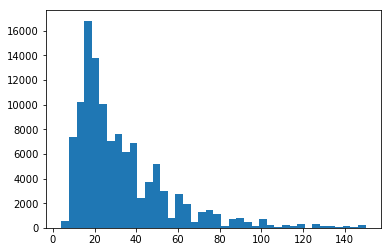

In [299]:
plt.hist(prices, bins=40)
plt.show()

In [260]:
max(prices)

199